# Multi-class classification based on Softmax and Cross-Entropy using pytorch

## import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm, tqdm_notebook
import random
import os

In [2]:
from google.colab import drive 
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## load data

In [3]:
directory_data  = './drive/MyDrive/Machine_Learning/'
filename_data   = 'assignment_06_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (20000, 32, 32)
size of y_train : (20000,)
*************************************************
size of x_test : (8000, 32, 32)
size of y_test : (8000,)
*************************************************
number of training image : 20000
height of training image : 32
width of training image : 32
*************************************************
number of testing image : 8000
height of testing image : 32
width of testing image : 32
*************************************************


## number of classes

In [4]:
print('*************************************************')
print('number of classes :', len(set(y_train)))
print('*************************************************')

*************************************************
number of classes : 10
*************************************************


## hyper-parameters

In [5]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 150
size_minibatch  = 128
learning_rate   = 0.0005
weight_decay    = 0.1

## custom data loader for the PyTorch framework

In [6]:
class dataset(Dataset):
    
    def __init__(self, image, label):
        
        self.image  = image
        self.label  = label.astype(np.long)
    
    def __getitem__(self, index):
        
        image   = self.image[index, :, :]
        label   = self.label[index, ]

        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.LongTensor([label])

        return image, label
    
    def __len__(self):
        
        return self.image.shape[0]

    def collate_fn(self, batch):
        images  = list()
        labels  = list()

        for b in batch:
            images.append(b[0])
            labels.append(b[1])

        images  = torch.stack(images, dim=0)
        labels  = torch.stack(labels, dim=0).squeeze()

        return images, labels
        

In [7]:
#https://forensics.tistory.com/29
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience  = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

## construct datasets and dataloaders for training and testing

In [8]:
dataset_train   = dataset(x_train, y_train)
dataset_test    = dataset(x_test, y_test)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_train.collate_fn)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_test.collate_fn)

## shape of the data when using the data loader

In [9]:
image, label    = next(iter(dataloader_train))
print('************************************************************')
print('size of mini-batch of the image:', image.shape)
print('************************************************************')
print('size of mini-batch of the label:', label.shape)
print('************************************************************')

************************************************************
size of mini-batch of the image: torch.Size([128, 1, 32, 32])
************************************************************
size of mini-batch of the label: torch.Size([128])
************************************************************


## class for the neural network 

In [10]:
class ResidualUnit(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1):
        super(ResidualUnit, self).__init__()

        self.main_layer = nn.Sequential (
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channel)
        )

        self.skip_layers = nn.Sequential()
        if stride > 1:
            self.skip_layers = nn.Sequential(
                nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_channel)
            )

        self.relu = nn.ReLU()

    def forward(self, x):
        Z = self.main_layer(x)
        Z += self.skip_layers(x)
        Z = self.relu(Z)
        return Z

In [11]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.featrue = nn.Sequential (
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # self.resnet = nn.Sequential(
        #     ResidualUnit(64, 64),
        #     ResidualUnit(64, 64),
        #     # ResidualUnit(48, 48),

        #     ResidualUnit(64, 96, stride=2),
        #     ResidualUnit(96, 96),
        #     ResidualUnit(96, 96),
        #     # ResidualUnit(96, 96),

        #     ResidualUnit(96, 128, stride=2),
        #     ResidualUnit(128, 128),
        #     ResidualUnit(128, 128),
        #     ResidualUnit(128, 128),
        #     # ResidualUnit(128, 128),
        #     # ResidualUnit(128, 128),

        #     ResidualUnit(128, 256, stride=2),
        #     ResidualUnit(256, 256),
        #     # ResidualUnit(256, 256)
        # )

        self.fc = nn.Sequential (
            nn.Flatten(),
            nn.Linear(4096, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

        self.network = nn.Sequential (
            self.featrue,
            self.fc
        )

        for m in self.network.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)


    def forward(self, x):
        Z = self.network(x)
        return Z

## build network

In [12]:
classifier  = Classifier()
optimizer   = torch.optim.SGD(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)
# from torchsummary import summary
# summary(classifier, (1, 28, 28), device="cpu")

## print the defined neural network

In [13]:
print(classifier)

Classifier(
  (featrue): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

## compute the prediction

In [14]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

In [15]:
def compute_loss(prediction, label):

    criterion   = nn.CrossEntropyLoss()
    loss        = criterion(prediction, label)
    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [16]:
def compute_accuracy(prediction, label):
    # ================================================================================ 
    # complete the function body
    b_Prediction = torch.argmax(prediction, 1)
    bCorrect = (b_Prediction == label)
    accuracy = bCorrect.float().mean() * 100
    # ================================================================================ 

    return accuracy

## variables for the learning curve

In [17]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train and test

In [18]:
## For Debugging
classifier  = Classifier().to(device)
optimizer   = torch.optim.SGD(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)
early_stopping = EarlyStopping(patience=70, verbose=1)

# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm_notebook(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    loss_train_epoch        = []
    accuracy_train_epoch    = []

    classifier.train()

    for index_batch, (image_train, label_train) in enumerate(dataloader_train):

        image_train = image_train.to(device)
        label_train = label_train.to(device)
        
        prediction_train                = compute_prediction(classifier, image_train)
        loss_train, loss_value_train    = compute_loss(prediction_train, label_train)
        accuracy_train                  = compute_accuracy(prediction_train, label_train).to("cpu")
        accuracy_train = accuracy_train.numpy()
        # loss_value_train = loss_value_train.to("cpu")

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        loss_train_epoch.append(loss_value_train)
        accuracy_train_epoch.append(accuracy_train)

    loss_mean_train[i]      = np.mean(loss_train_epoch)
    loss_std_train[i]       = np.std(loss_train_epoch)

    accuracy_mean_train[i]  = np.mean(accuracy_train_epoch)
    accuracy_std_train[i]   = np.std(accuracy_train_epoch)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    loss_test_epoch        = []
    accuracy_test_epoch    = []

    with torch.no_grad():
        classifier.eval()

    for index_batch, (image_test, label_test) in enumerate(dataloader_test):

        image_test = image_test.to(device)
        label_test = label_test.to(device)
        
        prediction_test             = compute_prediction(classifier, image_test)
        loss_test, loss_value_test  = compute_loss(prediction_test, label_test)
        accuracy_test               = compute_accuracy(prediction_test, label_test).to("cpu")
        accuracy_test = accuracy_test.numpy()

        loss_test_epoch.append(loss_value_test)
        accuracy_test_epoch.append(accuracy_test)

    loss_mean_test[i]      = np.mean(loss_test_epoch)
    loss_std_test[i]       = np.std(loss_test_epoch)

    accuracy_mean_test[i]  = np.mean(accuracy_test_epoch)
    accuracy_std_test[i]   = np.std(accuracy_test_epoch)

    if i % 5 == 0:
        print(f"epoch : {i}, train acc : {np.mean(accuracy_train_epoch)}, train loss : {np.mean(loss_train_epoch)}")
        print(f"epoch : {i}, test acc : {np.mean(accuracy_test_epoch)}, test loss : {np.mean(loss_test_epoch)}")
        print()

    # if early_stopping.validate(np.mean(loss_test_epoch)):
    #     break



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/150 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch : 0, train acc : 73.13701629638672, train loss : 0.9869071506919005
epoch : 0, test acc : 89.46572875976562, test loss : 0.5240884894324888

epoch : 5, train acc : 96.21394348144531, train loss : 0.21420236027393585
epoch : 5, test acc : 96.09375, test loss : 0.20902192472450196

epoch : 10, train acc : 97.37079620361328, train loss : 0.15908857989005554
epoch : 10, test acc : 96.96320343017578, test loss : 0.1668272827181124

epoch : 15, train acc : 97.8866195678711, train loss : 0.1393808439756051
epoch : 15, test acc : 97.27822875976562, test loss : 0.14771399947424088

epoch : 20, train acc : 98.34735870361328, train loss : 0.1293861568451692
epoch : 20, test acc : 97.4798355102539, test loss : 0.14006847924282473

epoch : 25, train acc : 98.52263641357422, train loss : 0.12489257213205864
epoch : 25, test acc : 97.70664978027344, test loss : 0.1359389710330194

epoch : 30, train acc : 98.70292663574219, train loss : 0.12463501773965664
epoch : 30, test acc : 97.8956680297851

## plot curve

In [19]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [20]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [21]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [22]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [23]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [24]:
def function_result_01():

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [25]:
def function_result_02():

    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [26]:
def function_result_03():
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [27]:
def function_result_04():
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [28]:
def function_result_05():
    
    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [29]:
def function_result_06():
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [30]:
def function_result_07():
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [31]:
def function_result_08():
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [32]:
def function_result_09():
    
    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [33]:
def function_result_10():
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---

## # 01. plot the training loss curve (mean, std)

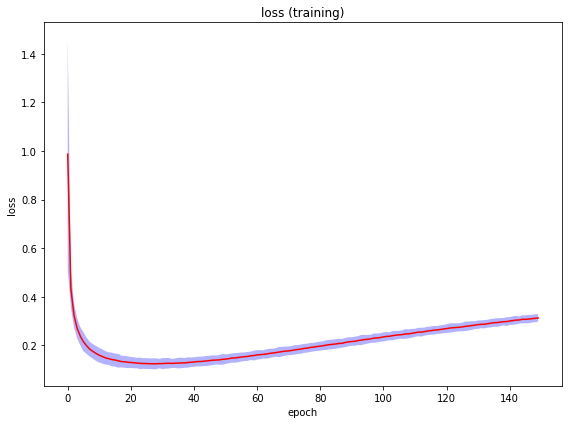

In [34]:
function_result_01()

## # 02. plot the training accuracy curve (mean, std)

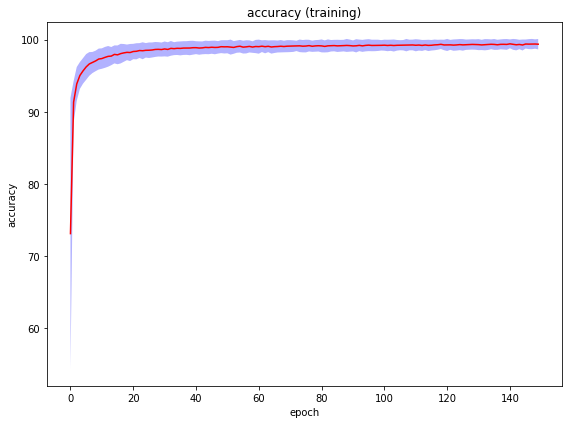

In [35]:
function_result_02()

## # 03. plot the testing loss curve (mean, std)

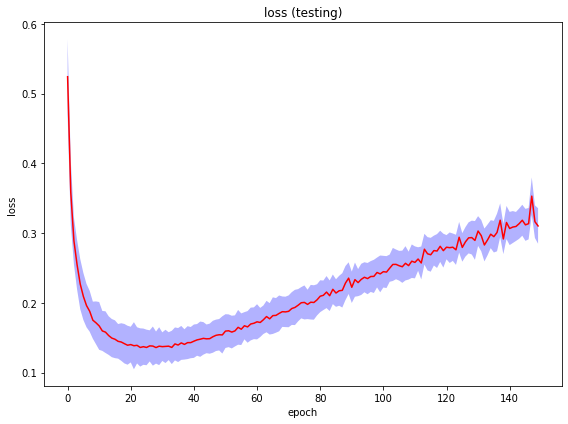

In [36]:
function_result_03()

## # 04. plot the testing accuracy curve (mean, std)

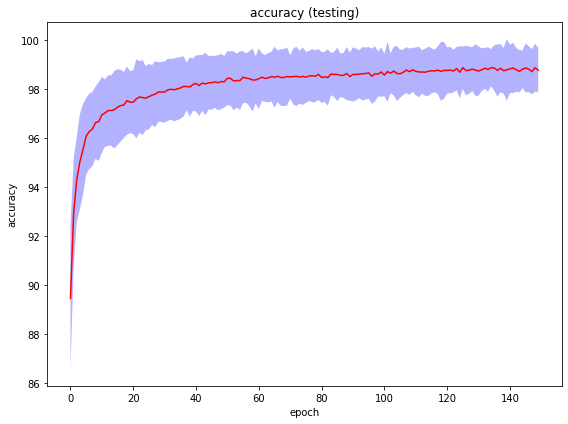

In [37]:
function_result_04()

## # 05. print the training (mean) loss over batches at last 10 epochs

In [38]:
function_result_05()

index =  0, value = 0.2999322779
index =  1, value = 0.3017156258
index =  2, value = 0.3037881003
index =  3, value = 0.3041335671
index =  4, value = 0.3071100920
index =  5, value = 0.3069429868
index =  6, value = 0.3079363562
index =  7, value = 0.3093965701
index =  8, value = 0.3111439689
index =  9, value = 0.3126265410


## # 06. print the training (mean) accuracy over batches at last 10 epochs

In [39]:
function_result_06()

index =  0, value = 99.4090576172
index =  1, value = 99.3389434814
index =  2, value = 99.2788467407
index =  3, value = 99.3239212036
index =  4, value = 99.2487945557
index =  5, value = 99.3840179443
index =  6, value = 99.3689880371
index =  7, value = 99.3790054321
index =  8, value = 99.3840179443
index =  9, value = 99.3589706421


## # 07. print the testing (mean) loss over batches at last 10 epochs

In [40]:
function_result_07()

index =  0, value = 0.3064813234
index =  1, value = 0.3085672269
index =  2, value = 0.3093922446
index =  3, value = 0.3133875261
index =  4, value = 0.3183269775
index =  5, value = 0.3117226208
index =  6, value = 0.3134173487
index =  7, value = 0.3529005089
index =  8, value = 0.3162785062
index =  9, value = 0.3101353506


## # 08. print the testing (mean) accuracy over batches at last 10 epochs

In [41]:
function_result_08()

index =  0, value = 98.8407287598
index =  1, value = 98.8785247803
index =  2, value = 98.8029251099
index =  3, value = 98.7399215698
index =  4, value = 98.8281250000
index =  5, value = 98.8785247803
index =  6, value = 98.8281250000
index =  7, value = 98.7273178101
index =  8, value = 98.8911285400
index =  9, value = 98.7903213501


## # 09. print the best training (mean) accuracy within the last 10 epochs

In [42]:
function_result_09()

best training accuracy = 99.4090576172


## # 10. print the best testing (mean) accuracy within the last 10 epochs

In [43]:
function_result_10()

best testing accuracy = 98.8911285400


In [44]:
accuracy_mean_train

array([73.1370163 , 91.34615326, 93.8551712 , 95.0270462 , 95.66306305,
       96.21394348, 96.62459564, 96.82492065, 97.04026794, 97.30568695,
       97.3707962 , 97.53605652, 97.67628479, 97.71134186, 97.94671631,
       97.88661957, 98.0568924 , 98.15705109, 98.2321701 , 98.20713043,
       98.3473587 , 98.37740326, 98.48257446, 98.45252228, 98.51261902,
       98.52263641, 98.55769348, 98.6328125 , 98.64783478, 98.61779022,
       98.70292664, 98.6328125 , 98.78305054, 98.74298859, 98.79306793,
       98.77804565, 98.82312012, 98.83312988, 98.828125  , 98.87319946,
       98.87820435, 98.828125  , 98.85316467, 98.9182663 , 98.89322662,
       98.93830109, 98.90825653, 98.92327881, 99.0134201 , 98.99339294,
       99.00340271, 98.95833588, 98.91326141, 99.0234375 , 99.07852936,
       98.95332336, 98.99339294, 99.05348206, 98.96334076, 99.03845978,
       99.01843262, 99.08353424, 99.0134201 , 99.06851196, 98.97335815,
       99.01843262, 99.03845978, 99.07852936, 99.03845978, 99.08

In [45]:
accuracy_mean_test

array([89.46572876, 92.93094635, 94.31703949, 95.04788208, 95.55191803,
       96.09375   , 96.28276062, 96.38356781, 96.64818573, 96.68598938,
       96.96320343, 97.03881073, 97.13961792, 97.13961792, 97.17742157,
       97.27822876, 97.3412323 , 97.36643219, 97.54283905, 97.47983551,
       97.47983551, 97.61844635, 97.69405365, 97.66885376, 97.64364624,
       97.70664978, 97.76966095, 97.80745697, 97.89566803, 97.89566803,
       97.89566803, 97.98387146, 98.00907135, 97.98387146, 98.02167511,
       98.05947876, 98.1224823 , 98.1224823 , 98.09727478, 98.19808197,
       98.24848938, 98.16028595, 98.26108551, 98.22328949, 98.27368927,
       98.27368927, 98.31149292, 98.27368927, 98.32408905, 98.31149292,
       98.46269989, 98.45010376, 98.34929657, 98.3618927 , 98.3618927 ,
       98.50050354, 98.46269989, 98.4375    , 98.38710022, 98.38710022,
       98.4375    , 98.50050354, 98.45010376, 98.47530365, 98.52570343,
       98.50050354, 98.53830719, 98.48789978, 98.48789978, 98.52